# **Cycling analysis**

---

## **Imports**

In [2]:
import requests
from bs4 import BeautifulSoup
import os
import re
from urllib.parse import urljoin
import selenium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline

---

## **Import csv files**

### **Inspect differences between CSV files**

In [3]:
# Define data folder
data_folder = "data/tfl_cycling_data"

# Get all CSV files
csv_files = sorted([f for f in os.listdir(data_folder) if f.endswith(".csv")])

# Dictionary to store column names for each file
column_map = {}

# Extract column names from each CSV file
for file in csv_files:
    df = pd.read_csv(os.path.join(data_folder, file), nrows=1)  # Read only first row for efficiency
    column_map[file] = set(df.columns)

# Find unique sets of column names
unique_column_sets = {}
for file, columns in column_map.items():
    columns_tuple = tuple(sorted(columns))  # Convert to tuple for dict keys (hashable)
    if columns_tuple not in unique_column_sets:
        unique_column_sets[columns_tuple] = []
    unique_column_sets[columns_tuple].append(file)

# Print summary of differences
for idx, (columns, files) in enumerate(unique_column_sets.items()):
    print(f"🔹 **Column Set {idx+1}: Found in {len(files)} files**")
    print(f"Files: {files[:5]}{'...' if len(files) > 5 else ''}")  # Show first few files
    print(f"Columns: {columns}\n")

🔹 **Column Set 1: Found in 89 files**
Files: ['246JourneyDataExtract23Dec2020-29Dec2020.csv', '246JourneyDataExtract30Dec2020-05Jan2021.csv', '247JourneyDataExtract06Jan2021-12Jan2021.csv', '248JourneyDataExtract13Jan2021-19Jan2021.csv', '249JourneyDataExtract20Jan2021-26Jan2021.csv']...
Columns: ('Bike Id', 'Duration', 'End Date', 'EndStation Id', 'EndStation Name', 'Rental Id', 'Start Date', 'StartStation Id', 'StartStation Name')

🔹 **Column Set 2: Found in 1 files**
Files: ['325JourneyDataExtract06Jul2022-12Jul2022.csv']
Columns: ('Bike Id', 'Duration', 'End Date', 'EndStation Name', 'Rental Id', 'Start Date', 'StartStation Id', 'StartStation Name')

🔹 **Column Set 3: Found in 53 files**
Files: ['335JourneyDataExtract12Sep2022-18Sep2022.csv', '336JourneyDataExtract19Sep2022-25Sep2022.csv', '337JourneyDataExtract26Sep2022-02Oct2022.csv', '338JourneyDataExtract03Oct2022-09Oct2022.csv', '339JourneyDataExtract10Oct2022-16Oct2022.csv']...
Columns: ('Bike model', 'Bike number', 'End date

### **Group similar files**

In [4]:
file_groups = {}

for idx, (columns, files) in enumerate(unique_column_sets.items()):
    var_name = f"group_{idx+1}"
    file_groups[var_name] =  files

# Access groups
group_1 = file_groups.get("group_1", [])
group_2 = file_groups.get("group_2", [])
group_3 = file_groups.get("group_3", [])

# Print to verify
print("Group 1 files:", group_1[:5])
print("Group 2 files:", group_2[:5])
print("Group 3 files:", group_3[:5])

Group 1 files: ['246JourneyDataExtract23Dec2020-29Dec2020.csv', '246JourneyDataExtract30Dec2020-05Jan2021.csv', '247JourneyDataExtract06Jan2021-12Jan2021.csv', '248JourneyDataExtract13Jan2021-19Jan2021.csv', '249JourneyDataExtract20Jan2021-26Jan2021.csv']
Group 2 files: ['325JourneyDataExtract06Jul2022-12Jul2022.csv']
Group 3 files: ['335JourneyDataExtract12Sep2022-18Sep2022.csv', '336JourneyDataExtract19Sep2022-25Sep2022.csv', '337JourneyDataExtract26Sep2022-02Oct2022.csv', '338JourneyDataExtract03Oct2022-09Oct2022.csv', '339JourneyDataExtract10Oct2022-16Oct2022.csv']


### **Separate unique files into separate Data Frames**

In [5]:
data_folder = "data/tfl_cycling_data"

df1_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_1]
df1 =  pd.concat(df1_batch, ignore_index=True)

df2_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_2]
df2 =  pd.concat(df2_batch, ignore_index=True)

df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]
df3 =  pd.concat(df3_batch, ignore_index=True)

/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_45275/993685103.py:9: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]
/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_45275/993685103.py:9: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]
/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_45275/993685103.py:9: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]


---

## **Rename columns**

#### **Comparison**  
- "Rental Id" -> "Number";  
- "Duration" (seconds) -> "Total duration (ms)" -------> delete column "Total duration";  
- "Bike Id" -> "Bike number";  
- "End Date" -> "End date";  
- "EndStation Id" -> "End station number";  
- "EndStation Name" -> "End station";  
- "Start Date" -> "Start date";  
- "StartStation Id" -> "Start station number";  
- "StartStation Name" -> "Start station";  

Only in second dataset:  
- "Bike model"
- "Total duration"

In [6]:
list(df1.columns)

['Rental Id',
 'Duration',
 'Bike Id',
 'End Date',
 'EndStation Id',
 'EndStation Name',
 'Start Date',
 'StartStation Id',
 'StartStation Name']

In [7]:
new_col_names_df1 = {
    'Rental Id': "rental_id",
    'Duration': "duration",
    'Bike Id': "bike_id",
    'End Date': "end_date",
    'EndStation Id': "end_station_id",
    'EndStation Name' :"end_station_name",
    'Start Date': "start_date",
    'StartStation Id': "start_station_id",
    'StartStation Name': "start_station_name"
}

In [8]:
df1 = df1.rename(columns=new_col_names_df1)
df1.head()

,rental_id,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name
0,104666386,5100,17552,24/12/2020 18:19,107,"Finsbury Leisure Centre, St. Luke's",24/12/2020 16:54,30,"Windsor Terrace, Hoxton"
1,104708347,2400,12134,27/12/2020 14:37,194,"Hop Exchange, The Borough",27/12/2020 13:57,298,"Curlew Street, Shad Thames"
2,104664061,300,18429,24/12/2020 15:23,91,"Walnut Tree Walk, Vauxhall",24/12/2020 15:18,272,"Baylis Road, Waterloo"
3,104723992,1440,17175,28/12/2020 13:30,742,"Blenheim Crescent, Ladbroke Grove",28/12/2020 13:06,303,"Albert Gate, Hyde Park"
4,104721666,840,15313,28/12/2020 11:23,307,"Black Lion Gate, Kensington Gardens",28/12/2020 11:09,742,"Blenheim Crescent, Ladbroke Grove"


In [9]:
# Convert 'start_date' and 'end_date' to datetime
df1['start_date'] = pd.to_datetime(df1['start_date'], errors='coerce')
df1['end_date'] = pd.to_datetime(df1['end_date'], errors='coerce')

/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_45275/798039224.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1['start_date'] = pd.to_datetime(df1['start_date'], errors='coerce')
/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_45275/798039224.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1['end_date'] = pd.to_datetime(df1['end_date'], errors='coerce')


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19517751 entries, 0 to 19517750
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rental_id           int64         
 1   duration            int64         
 2   bike_id             int64         
 3   end_date            datetime64[ns]
 4   end_station_id      int64         
 5   end_station_name    object        
 6   start_date          datetime64[ns]
 7   start_station_id    int64         
 8   start_station_name  object        
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 1.3+ GB


In [11]:
list(df2.columns)

['Rental Id',
 'Duration',
 'Bike Id',
 'End Date',
 'EndStation Name',
 'Start Date',
 'StartStation Id',
 'StartStation Name']

In [12]:
# does not have EndStation Id

new_col_names_df2 = {
    'Rental Id': "rental_id",
    'Duration': "duration",
    'Bike Id': "bike_id",
    'End Date': "end_date",
    'EndStation Name' :"end_station_name",
    'Start Date': "start_date",
    'StartStation Id': "start_station_id",
    'StartStation Name': "start_station_name"
}

In [13]:
df2 = df2.rename(columns=new_col_names_df2)
df2.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_id,start_station_name
0,122342973,180,16835,06/07/2022 15:26,"St. Mary & St. Michael Church, Stepney",06/07/2022 15:23,500,"Ansell House, Stepney"
1,122443043,1380,8260,08/07/2022 18:09,"Belgrove Street , King's Cross",08/07/2022 17:46,297,"Geraldine Street, Elephant & Castle"
2,122392666,600,17431,07/07/2022 17:00,"Eel Brook Common, Walham Green",07/07/2022 16:50,615,"Finlay Street, Fulham"
3,122516692,900,39,10/07/2022 11:47,"Drury Lane, Covent Garden",10/07/2022 11:32,310,"Black Prince Road, Vauxhall"
4,122561553,1140,6484,11/07/2022 09:55,"Duke Street Hill, London Bridge",11/07/2022 09:36,310,"Black Prince Road, Vauxhall"


In [14]:
# Convert 'start_date' and 'end_date' to datetime
df2['start_date'] = pd.to_datetime(df2['start_date'], errors='coerce')
df2['end_date'] = pd.to_datetime(df2['end_date'], errors='coerce')

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312144 entries, 0 to 312143
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   rental_id           312144 non-null  int64         
 1   duration            312144 non-null  int64         
 2   bike_id             312144 non-null  int64         
 3   end_date            312144 non-null  datetime64[ns]
 4   end_station_name    312144 non-null  object        
 5   start_date          312144 non-null  datetime64[ns]
 6   start_station_id    312144 non-null  int64         
 7   start_station_name  312144 non-null  object        
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 19.1+ MB


In [16]:
list(df3.columns)

['Number',
 'Start date',
 'Start station number',
 'Start station',
 'End date',
 'End station number',
 'End station',
 'Bike number',
 'Bike model',
 'Total duration',
 'Total duration (ms)']

In [17]:
df3['duration'] = df3['Total duration (ms)'] / 1000
df3.duration.head()

0    7934.133
1     736.233
2     929.662
3    1411.818
4    1400.619
Name: duration, dtype: float64

In [18]:
new_col_names_df3 = {
    'Number': "rental_id",
    'duration': "duration",
    'Bike number': "bike_id",
    'End date': "end_date",
    'End station number': "end_station_id",
    'End station' :"end_station_name",
    'Start date': "start_date",
    'Start station number': "start_station_id",
    'Start station': "start_station_name",
    "Bike model": "model",
    'Total duration': "total_duration",
    'Total duration (ms)': "total_duration_ms"
}

In [19]:
df3 = df3.rename(columns=new_col_names_df3)
df3.head()

,rental_id,start_date,start_station_id,start_station_name,end_date,end_station_id,end_station_name,bike_id,model,total_duration,total_duration_ms,duration
0,125230172,2022-09-18 23:59,001059,"Albert Embankment, Vauxhall",2022-09-19 02:11,200222,"Danvers Street, West Chelsea",54170,CLASSIC,2h 12m 14s,7934133,7934.133
1,125230173,2022-09-18 23:59,002660,"Frith Street, Soho",2022-09-19 00:11,001194,"Westminster University, Marylebone",50087,CLASSIC,12m 16s,736233,736.233
2,125230174,2022-09-18 23:59,001183,"Bramham Gardens, Earl's Court",2022-09-19 00:14,300019,"Felsham Road, Putney",54561,CLASSIC,15m 29s,929662,929.662
3,125230175,2022-09-18 23:59,010624,"Strata, Elephant & Castle",2022-09-19 00:23,300252,"Canada Water Station, Rotherhithe",54324,CLASSIC,23m 31s,1411818,1411.818
4,125230176,2022-09-18 23:59,010624,"Strata, Elephant & Castle",2022-09-19 00:23,300252,"Canada Water Station, Rotherhithe",22065,CLASSIC,23m 20s,1400619,1400.619


In [20]:
# Convert 'start_date' and 'end_date' to datetime
df3['start_date'] = pd.to_datetime(df3['start_date'], errors='coerce')
df3['end_date'] = pd.to_datetime(df3['end_date'], errors='coerce')

In [21]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11059475 entries, 0 to 11059474
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rental_id           int64         
 1   start_date          datetime64[ns]
 2   start_station_id    object        
 3   start_station_name  object        
 4   end_date            datetime64[ns]
 5   end_station_id      object        
 6   end_station_name    object        
 7   bike_id             int64         
 8   model               object        
 9   total_duration      object        
 10  total_duration_ms   int64         
 11  duration            float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 1012.5+ MB


---

### **Drop columns + store Data Frame with bike model for later use**

In [22]:
df_with_model = df3.drop(columns=["total_duration_ms", "total_duration"], axis=1)

In [23]:
# check distribution amongst bike models
df_with_model.model.value_counts(normalize=True)

model
CLASSIC       0.932367
PBSC_EBIKE    0.067633
Name: proportion, dtype: float64

In [24]:
# df3 excluding model feature to be used going forward
df3 = df_with_model.drop(columns=["model"], axis=1)

---

## **Drop ID columns as they are inconsistent in df3**

We will create our own IDs later on

In [25]:
# drop start_station_id
# drop end_station_id

df1 = df1.drop(columns=["start_station_id", "end_station_id"], axis=1)
df2 = df2.drop(columns=["start_station_id"], axis=1) # df2 never had an end_station_id to begin with
df3 = df3.drop(columns=["start_station_id", "end_station_id"], axis=1)

In [26]:
# Check columns are consistent
print(sorted(df1.columns) == sorted(df2.columns))
print(sorted(df1.columns) == sorted(df3.columns))

True
True


---

## **Concatenate Data Frames**

In [27]:
# Match df2 and df3 to the column order of df1
df2 = df2[df1.columns]
df3 =  df3[df1.columns]

# Concatenate data frames
df_combined = pd.concat([df1,df2,df3], ignore_index=True)
df_combined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name
0,104666386,5100.0,17552,2020-12-24 18:19:00,"Finsbury Leisure Centre, St. Luke's",2020-12-24 16:54:00,"Windsor Terrace, Hoxton"
1,104708347,2400.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames"
2,104664061,300.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo"
3,104723992,1440.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park"
4,104721666,840.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove"


---

## **Create new IDs**

Create new <code>start_station_id</code> based on <code>start_station_name</code>.  
Create new <code>end_station_id</code> based on <code>end_station_name</code>.  

In [28]:
# Find unique list of all station names
all_station_names = pd.concat([df_combined['start_station_name'], df_combined['end_station_name']]).unique()

# Map the stations
station_mapping = {name: idx for idx, name in enumerate(all_station_names, start=1)}

# Map the station names to their corresponding IDs
df_combined['start_station_id'] = df_combined['start_station_name'].map(station_mapping)
df_combined['end_station_id'] = df_combined['end_station_name'].map(station_mapping)

print(df_combined.head())

# Check for missing values in new IDs
print(df_combined[['start_station_id', 'end_station_id']].isnull().sum())

   rental_id  duration  bike_id            end_date  \
0  104666386    5100.0    17552 2020-12-24 18:19:00   
1  104708347    2400.0    12134 2020-12-27 14:37:00   
2  104664061     300.0    18429 2020-12-24 15:23:00   
3  104723992    1440.0    17175 2020-12-28 13:30:00   
4  104721666     840.0    15313 2020-12-28 11:23:00   

                      end_station_name          start_date  \
0  Finsbury Leisure Centre, St. Luke's 2020-12-24 16:54:00   
1            Hop Exchange, The Borough 2020-12-27 13:57:00   
2           Walnut Tree Walk, Vauxhall 2020-12-24 15:18:00   
3    Blenheim Crescent, Ladbroke Grove 2020-12-28 13:06:00   
4  Black Lion Gate, Kensington Gardens 2020-12-28 11:09:00   

                  start_station_name  start_station_id  end_station_id  
0            Windsor Terrace, Hoxton                 1             397  
1         Curlew Street, Shad Thames                 2             306  
2              Baylis Road, Waterloo                 3             372  
3   

In [29]:
df_combined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name,start_station_id,end_station_id
0,104666386,5100.0,17552,2020-12-24 18:19:00,"Finsbury Leisure Centre, St. Luke's",2020-12-24 16:54:00,"Windsor Terrace, Hoxton",1,397
1,104708347,2400.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames",2,306
2,104664061,300.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo",3,372
3,104723992,1440.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park",4,5
4,104721666,840.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove",5,435


---

## **Convert duration to minutes from seconds for readability**

In [30]:
df_combined['duration'] = df_combined['duration'] / 60

---

# **EDA**

In [31]:
df_combined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name,start_station_id,end_station_id
0,104666386,85.0,17552,2020-12-24 18:19:00,"Finsbury Leisure Centre, St. Luke's",2020-12-24 16:54:00,"Windsor Terrace, Hoxton",1,397
1,104708347,40.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames",2,306
2,104664061,5.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo",3,372
3,104723992,24.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park",4,5
4,104721666,14.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove",5,435


## **Overview**

In [32]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30889370 entries, 0 to 30889369
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rental_id           int64         
 1   duration            float64       
 2   bike_id             int64         
 3   end_date            datetime64[ns]
 4   end_station_name    object        
 5   start_date          datetime64[ns]
 6   start_station_name  object        
 7   start_station_id    int64         
 8   end_station_id      int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 2.1+ GB


In [33]:
# check for missing values
df_combined.isnull().sum()

rental_id             0
duration              0
bike_id               0
end_date              0
end_station_name      0
start_date            0
start_station_name    0
start_station_id      0
end_station_id        0
dtype: int64

In [34]:
# drop duplicates
df_combined.drop_duplicates(inplace=True)

---

## **Add Features**

In [ ]:
# Add time of the day a bike was used
df_combined['time_of_day'] = pd.to_datetime(df_combined['start_date']).dt.hour

In [ ]:
# Add day of weeke bike was used
df_combined['day_of_the_week'] = df_combined['start_date'].dt.day_name()

In [ ]:
# Number of unique stations
unique_stations = df_combined.start_station_name.nunique()
print(f"There are {unique_stations} unique stations in the dataset")

There are 829 unique stations in the dataset


In [ ]:
# Net flows
station_usage = df_combined.groupby('start_station_name').size() - df_combined.groupby('end_station_name').size()

---

## **Rental Trends Over Time**

### **Daily Trends**

<Axes: title={'center': 'Daily Rental Trends'}, xlabel='start_date'>

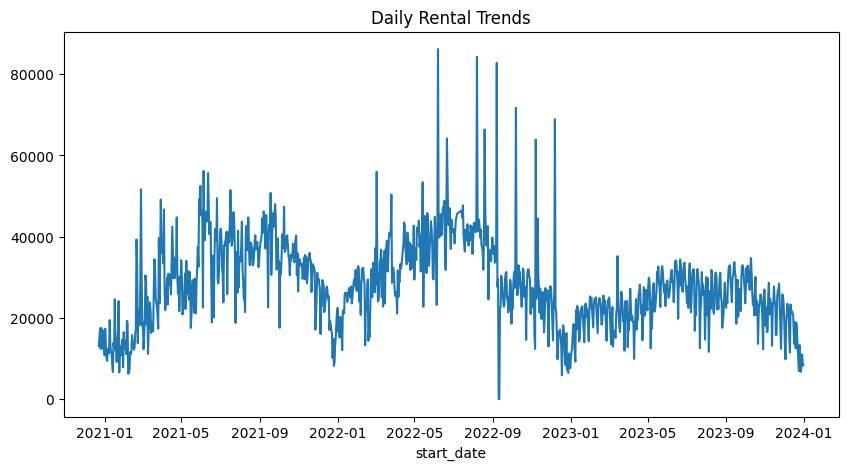

In [35]:
df_combined['start_date'].dt.date.value_counts().sort_index().plot(
    kind='line', figsize=(10,5), title="Daily Rental Trends")

**Insight**:  
- General trend follows the seasons (usage is lower in winter months around Jan and picks up moving into European summer around June).  
- Some spikes are noticeable between Jun-22 and Dec-23. Unclear what these could be (maybe other modes of transport were not working at those times?).
- Overall appears to be somewhat stable usage y-o-y from 2021 to 2022 (excluding 2022 spikes).  
- However, 2023 appears to have declined. Why? Is this anticipated to continue?

### **Trend by Month**

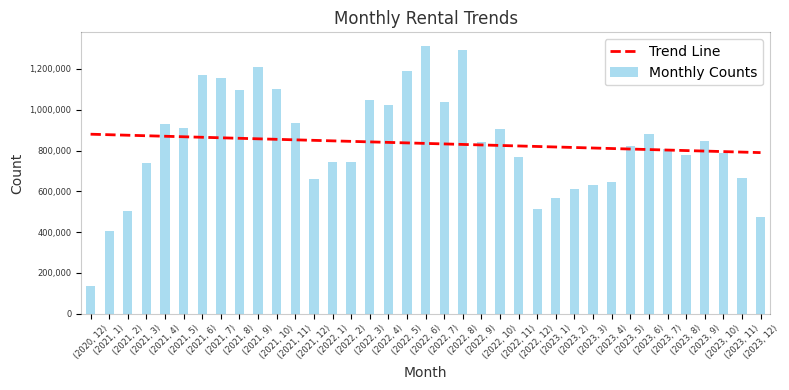

In [36]:
# Group by year and month
monthly_trend = df_combined.groupby([df_combined['start_date'].dt.year, df_combined['start_date'].dt.month]).size()

# Numeric index for plotting
x = np.arange(len(monthly_trend))
y = monthly_trend.values

# Uses np.polyfit to fit a linear regression line
trend = np.poly1d(np.polyfit(x, y, deg=1))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot bar chart
monthly_trend.plot(kind="bar", ax=ax, color="skyblue", alpha=0.7, label="Monthly Counts")

# Plot trend line
ax.plot(x, trend(x), color="red", linestyle="--", linewidth=2, label="Trend Line")

# Title and labels
plt.title('Monthly Rental Trends', alpha=0.8)
plt.xlabel('Month', alpha=0.8)
plt.ylabel('Count', alpha=0.8)

# Format y-axis with thousands separator
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# X-axis formatting
plt.xticks(rotation=45, alpha=0.8)
plt.tick_params(axis='x', labelsize=6)

# Y-axis formatting
plt.yticks(alpha=0.8)
plt.tick_params(axis='y', labelsize=6)

# Adjust spine visibility
for spine in ax.spines.values():
    spine.set_alpha(0.2)

plt.legend()
plt.tight_layout()
plt.show()

**Insight**:  
- Declining trend in usage over time.

---

## **Trip Duration Analysis**

<Axes: ylabel='Frequency'>

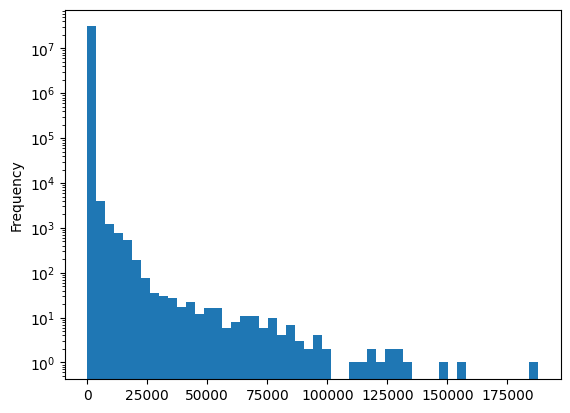

In [37]:
# Assess distribution of durations
# Log scale for visibility
df_combined['duration'].plot(kind='hist', bins=50, logy=True)

**Insight**:  
- Heavy concentration < 25000 mins.

In [38]:
# Check min, max, mean
df_combined['duration'].describe()

count    3.088937e+07
mean     2.260651e+01
std      2.296425e+02
min      1.215000e-02
25%      8.047967e+00
50%      1.400000e+01
75%      2.200000e+01
max      1.877506e+05
Name: duration, dtype: float64

In [39]:
df_combined.duration.sort_values(ascending=False)

30530726    187750.646433
30733319    154998.239717
27340939    150044.080800
27343249    133255.303550
27332645    128425.874250
                ...      
25080273         0.014917
21081411         0.014350
20217343         0.013850
20251210         0.013650
21255911         0.012150
Name: duration, Length: 30889370, dtype: float64

---

## **Busiest Days & Hours**

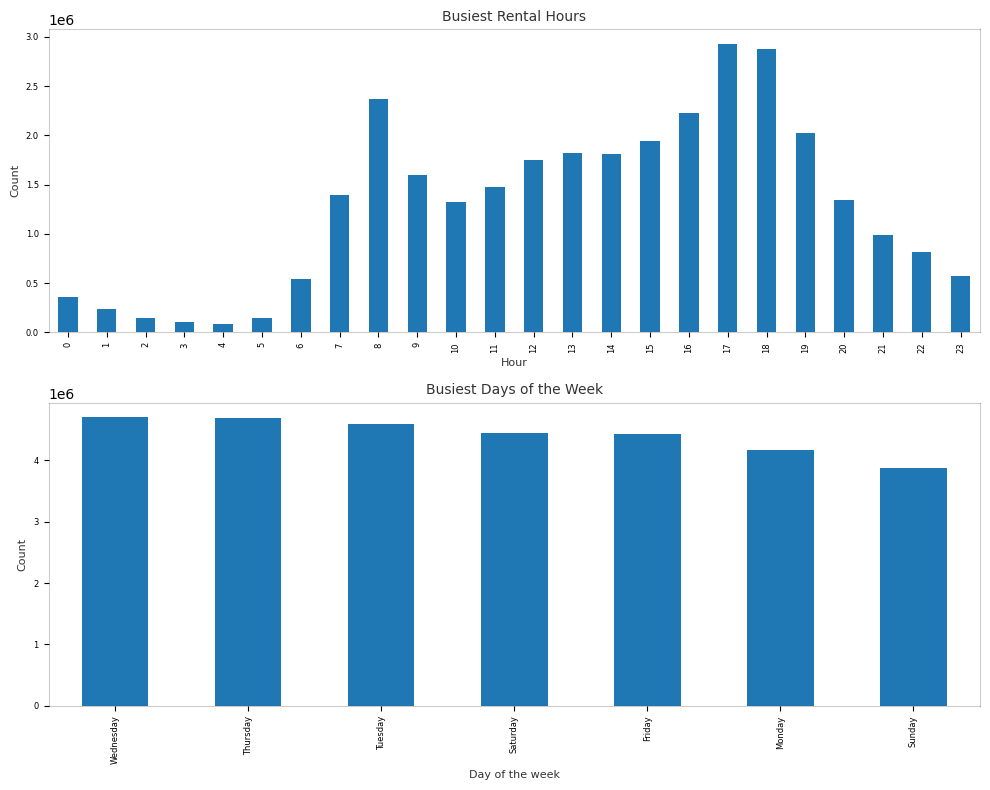

In [40]:
fig,ax = plt.subplots(2,1,figsize=(10,8))

df_combined['hour'] = df_combined['start_date'].dt.hour
df_combined['day_of_week'] = df_combined['start_date'].dt.day_name()

df_combined['hour'].value_counts().sort_index().plot(kind='bar', ax=ax[0])
df_combined['day_of_week'].value_counts().plot(kind='bar', ax=ax[1])

# Top 10 start stations
ax[0].set_title('Busiest Rental Hours', alpha=0.8, fontsize=10)
ax[0].set_ylabel('Count', alpha=0.8, fontsize=8)
ax[0].set_xlabel('Hour', alpha=0.8, fontsize=8)
ax[0].tick_params(axis='x', labelsize=6)
ax[0].tick_params(axis='y', labelsize=6)
for spine in ax[0].spines.values():
    spine.set_alpha(0.2)

# Top  10 end stations
ax[1].set_title('Busiest Days of the Week', alpha=0.8, fontsize=10)
ax[1].set_ylabel('Count', alpha=0.8, fontsize=8)
ax[1].set_xlabel('Day of the week', alpha=0.8, fontsize=8)
ax[1].tick_params(axis='x', labelsize=6)
ax[1].tick_params(axis='y', labelsize=6)
for spine in ax[1].spines.values():
    spine.set_alpha(0.2)

plt.tight_layout()
plt.show()

---

## **Most popular stations**

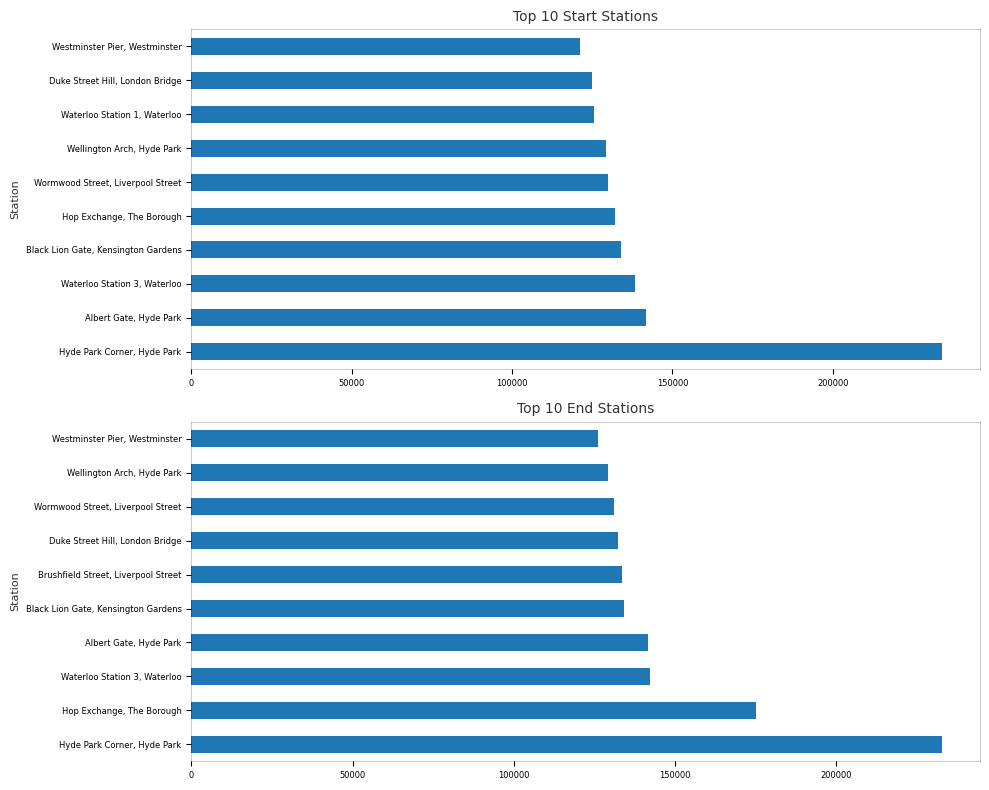

In [41]:
fig,ax = plt.subplots(2,1,figsize=(10,8))

df_combined['start_station_name'].value_counts().head(10).plot(kind='barh', ax=ax[0])
df_combined['end_station_name'].value_counts().head(10).plot(kind='barh', ax=ax[1])

# Top 10 start stations
ax[0].set_title('Top 10 Start Stations', alpha=0.8, fontsize=10)
ax[0].set_ylabel('Station', alpha=0.8, fontsize=8)
ax[0].tick_params(axis='x', labelsize=6)
ax[0].tick_params(axis='y', labelsize=6)
for spine in ax[0].spines.values():
    spine.set_alpha(0.2)

# Top  10 end stations
ax[1].set_title('Top 10 End Stations', alpha=0.8, fontsize=10)
ax[1].set_ylabel('Station', alpha=0.8, fontsize=8)
ax[1].tick_params(axis='x', labelsize=6)
ax[1].tick_params(axis='y', labelsize=6)
for spine in ax[1].spines.values():
    spine.set_alpha(0.2)

plt.tight_layout()
plt.show()

**Insight**: Hyde Park appears to be a central station where net inflows is close to zero.

---

## **Bike usage patterns**

- Compare the net flow of bikes between the morning and evening at each station to identify patterns of inflows and outflows at different times of day.  
- We would expect to see a larger % of people using bikes in the morning for commuting.  

In [111]:
# Isolate trips taken during the week -> filter out weekends
weekday_filter = df_combined[df_combined['start_date'].dt.day_of_week < 5]

In [112]:
# Organise data between weekday trips in the morning and those in the evening

# Weekday mornings (between 7am and 9am)
weekday_morning = weekday_filter[(weekday_filter['time_of_day'] >= 7) & (weekday_filter['time_of_day'] <= 9)]

# Weekday evenings (between 5pm and 7pm)
weekday_evening = weekday_filter[(weekday_filter['time_of_day'] >= 17) & (weekday_filter['time_of_day'] <= 19)]

In [113]:
# Calculate net flows by station during week in the morning & evening
# start_station_name.size(): Counts how many bikes left the station (outflows)
# end_station_name.size(): Counts how many bikes returned to the station (inflows)

weekday_morning_station_usage = weekday_morning.groupby('start_station_name').size() - weekday_morning.groupby('end_station_name').size()
weekday_evening_station_usage = weekday_evening.groupby('start_station_name').size() - weekday_evening.groupby('end_station_name').size()

**Note**:  
- If the result is positive, it indicates that more bikes were taken out than returned (more outflows).  
- If the result is negative, it indicates more bikes were returned than taken out (more inflows).  

In [114]:
weekday_morning_station_usage = weekday_morning_station_usage.to_frame().reset_index()
weekday_evening_station_usage = weekday_evening_station_usage.to_frame().reset_index()

In [115]:
weekday_morning_station_usage.rename(columns={"index": 'station', 0: 'net_flow_morning'}, inplace=True)
weekday_evening_station_usage.rename(columns={"index": 'station', 0: 'net_flow_evening'}, inplace=True)

In [116]:
# Interested in stations that appear in both datasets to assess differences in net flows based on time of day
weekday_morning_evening_merged = weekday_morning_station_usage.merge(right=weekday_evening_station_usage, on='station', how='inner')

In [117]:
weekday_morning_evening_merged.head()

,station,net_flow_morning,net_flow_evening
0,"Abbey Orchard Street, Westminster",-14076.0,8631.0
1,"Abbotsbury Road, Holland Park",870.0,-107.0
2,"Aberdeen Place, St. John's Wood",3226.0,-1499.0
3,"Aberfeldy Street, Poplar",827.0,-578.0
4,"Abingdon Green, Westminster",-9484.0,5840.0


In [118]:
weekday_morning_evening_merged['flow_difference'] = weekday_morning_evening_merged['net_flow_morning'] - weekday_morning_evening_merged['net_flow_evening']
weekday_morning_evening_merged.head()

In [124]:
# Top 10 stations for outflows
weekday_morning_top10 = weekday_morning_evening_merged.sort_values(by="flow_difference", ascending=False).head(10)

# Top 10 stations for inflows
weekday_evening_top10 = weekday_morning_evening_merged.sort_values(by="flow_difference", ascending=True).head(10)

<Figure size 1200x600 with 0 Axes>

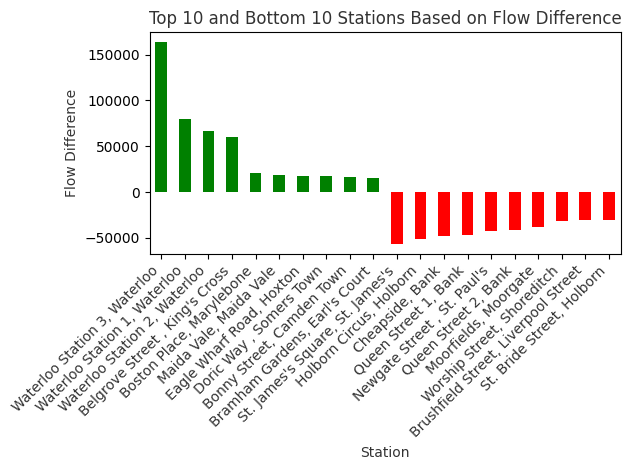

In [126]:
# Select top 10 and bottom 10 stations
top_10_stations = weekday_morning_evening_merged.sort_values(by='flow_difference', ascending=False).head(10)
bottom_10_stations = weekday_morning_evening_merged.sort_values(by='flow_difference', ascending=True).head(10)

# Combine top and bottom stations for comparison
combined_stations = pd.concat([top_10_stations, bottom_10_stations])

# Plot bar chart
plt.figure(figsize=(12, 6))
combined_stations.plot(kind='bar', x='station', y='flow_difference', color=['green']*10 + ['red']*10, legend=False)

plt.title('Top 10 and Bottom 10 Stations Based on Flow Difference', alpha=0.8)
plt.xlabel('Station', alpha=0.8)
plt.ylabel('Flow Difference', alpha=0.8)
plt.xticks(rotation=45, ha='right', alpha=0.8)
plt.tight_layout()

# Show plot
plt.show()

<Axes: title={'center': 'Most Used Bikes'}, xlabel='bike_id'>

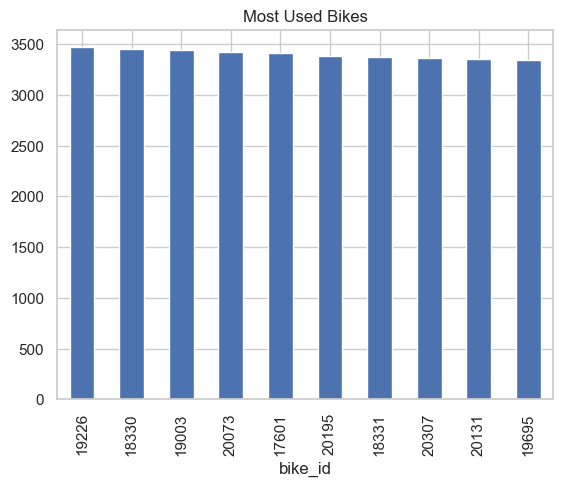

In [131]:
df_combined['bike_id'].value_counts().head(10).plot(kind='bar', title="Most Used Bikes")

---

## **Station imbalances**

<Axes: title={'center': 'Station Demand vs. Supply'}>

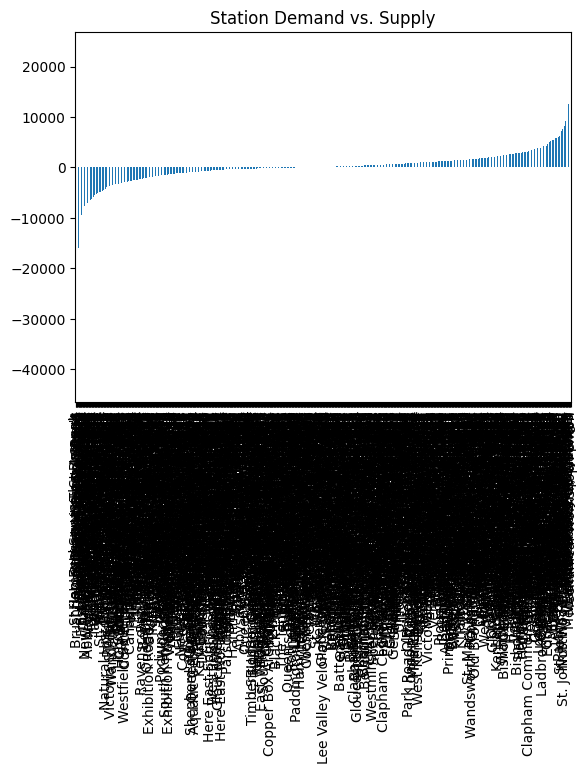

In [45]:
station_usage = df_combined.groupby('start_station_name').size() - df_combined.groupby('end_station_name').size()
station_usage.sort_values().plot(kind='bar', title="Station Demand vs. Supply")

**Insight**:  
- This chart is not particularly useful but serves to show that stations on either end have demand vs supply imbalances.
- How does this impact supply chain considerations?  

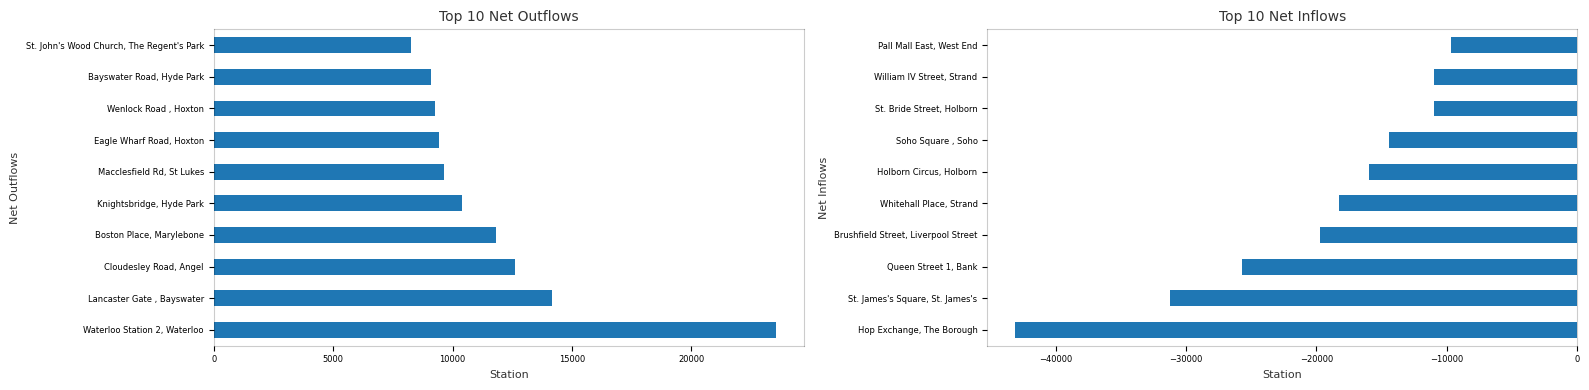

In [46]:
# Visualise demand vs supply imbalances

fig, ax = plt.subplots(1,2, figsize=(16,4))

top_10_net_outflow = station_usage.sort_values(ascending=False)[:10]
top_10_net_inflow = station_usage.sort_values(ascending=True)[:10]

top_10_net_outflow.plot(kind='barh',ax=ax[0])
top_10_net_inflow.plot(kind='barh',ax=ax[1])

# Net outflows
ax[0].set_title('Top 10 Net Outflows', alpha=0.8, fontsize=10)
ax[0].set_xlabel('Station', alpha=0.8, fontsize=8)
ax[0].set_ylabel('Net Outflows', alpha=0.8, fontsize=8)
ax[0].tick_params(axis='x', labelsize=6)
ax[0].tick_params(axis='y', labelsize=6)
for spine in ax[0].spines.values():
    spine.set_alpha(0.2)

# Net inflows
ax[1].set_title('Top 10 Net Inflows', alpha=0.8, fontsize=10)
ax[1].set_xlabel('Station', alpha=0.8, fontsize=8)
ax[1].set_ylabel('Net Inflows', alpha=0.8, fontsize=8)
ax[1].tick_params(axis='x', labelsize=6)
ax[1].tick_params(axis='y', labelsize=6)
for spine in ax[1].spines.values():
    spine.set_alpha(0.2)

plt.tight_layout()
plt.show()

**Insight**: Possible reasons for differences noted in the the count of trips starting at a station minus the count of trips ending at that station is.  

Positive difference: More trips start here than end here. This station is a bike source (bikes are frequently taken but not returned as often).  
Possible reasons:  
- Located in residential areas (people start trips here to commute elsewhere).  
- Near transit hubs (people rent bikes to get to work or school).  
- Could experience bike shortages if not replenished.  

Negative: More trips end here than start here. This station is a bike sink (bikes are frequently dropped off but not taken as often).  
Possible reasons:  
- Located in office districts, universities, or shopping areas (people ride here but don’t start trips as frequently).  
- Could experience bike congestion, requiring redistribution.  

---

## **Create categories of users**

**Rationale**:
- Bucket users into new categories based on the length of time they use a bike for.  
- This will help us understand the profile of potential customers.  

In [47]:
def categorise_trip(duration):
    if duration < 10:
        return "quick_errand"
    elif duration < 30:
        return "commute"
    elif duration < 60:
        return "leisure_ride"
    else:
        return "long_trip" # tourism?

df_combined['trip_category'] = df_combined['duration'].apply(categorise_trip)

In [48]:
df_combined.trip_category.value_counts(normalize=True)

trip_category
commute         0.562019
quick_errand    0.313473
leisure_ride    0.090367
long_trip       0.034141
Name: proportion, dtype: float64

<Figure size 1200x600 with 0 Axes>

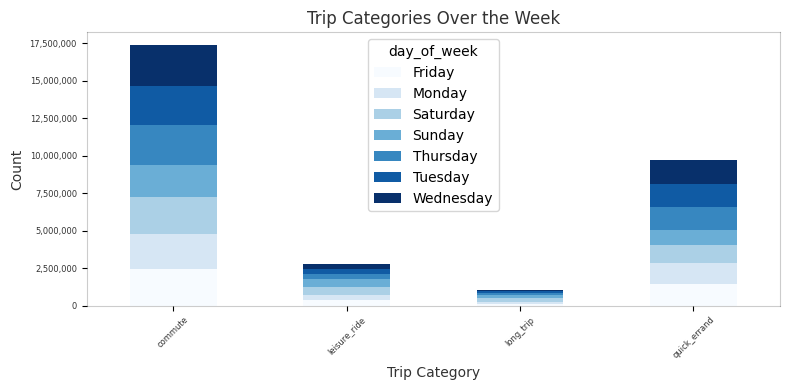

In [ ]:
fig = plt.figure(figsize=(12,6))

category_day_count = df_combined.groupby(['trip_category', 'day_of_week']).size().sort_values(ascending=False).unstack(fill_value=0)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot bar chart
category_day_count.plot(kind='bar', ax=ax, stacked=True, colormap='Blues')

# Customize the plot
plt.title('Trip Categories Over the Week', alpha=0.8)
plt.xlabel('Trip Category', alpha=0.8)
plt.ylabel('Count', alpha=0.8)
plt.xticks(rotation=45, alpha=0.8)
plt.tick_params(axis='x', labelsize=6)
plt.yticks(alpha=0.8)
plt.tick_params(axis='y', labelsize=6)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))
for spine in plt.gca().spines.values():
    spine.set_alpha(0.2)
plt.tight_layout()
plt.show()

**Insight**:  
- Commutes & quick errands comprise a significant share of the trips.  
- Within a category (i.e. commute) the number of trips is largely consistent across the week.

In [50]:
df_combined.groupby(['trip_category', 'day_of_the_week']).size().sort_values(ascending=False)['commute']

day_of_the_week
Wednesday    2692143
Thursday     2683737
Tuesday      2625428
Friday       2454801
Saturday     2450874
Monday       2328352
Sunday       2125084
dtype: int64

In [51]:
df_counts = df_combined.groupby(['trip_category', 'day_of_the_week']).size()

df_percentage = df_counts.groupby(level=1).apply(lambda x: (x / x.sum()) * 100)

print(df_percentage)

day_of_the_week  trip_category  day_of_the_week
Friday           commute        Friday             55.497200
                 leisure_ride   Friday              8.312120
                 long_trip      Friday              3.065774
                 quick_errand   Friday             33.124906
Monday           commute        Monday             55.954693
                 leisure_ride   Monday              8.021724
                 long_trip      Monday              2.890964
                 quick_errand   Monday             33.132619
Saturday         commute        Saturday           55.153270
                 leisure_ride   Saturday           12.655187
                 long_trip      Saturday            5.532668
                 quick_errand   Saturday           26.658874
Sunday           commute        Sunday             54.761780
                 leisure_ride   Sunday             12.644549
                 long_trip      Sunday              6.011034
                 quick_errand   Sunda

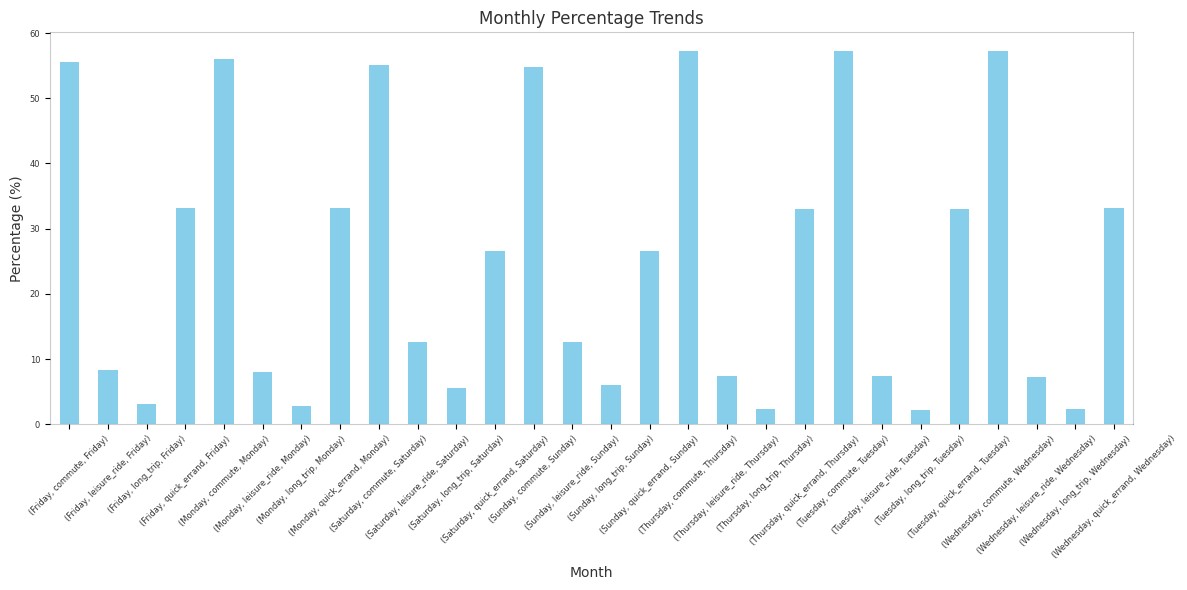

In [52]:
# Plot percentage data
fig, ax = plt.subplots(figsize=(12, 6))

df_percentage.plot(kind='bar', ax=ax, color='skyblue')

# Title and labels
plt.title('Monthly Percentage Trends', alpha=0.8)
plt.xlabel('Month', alpha=0.8)
plt.ylabel('Percentage (%)', alpha=0.8)

# Formatting x and y axes
plt.xticks(rotation=45, alpha=0.8)
plt.tick_params(axis='x', labelsize=6)
plt.yticks(alpha=0.8)
plt.tick_params(axis='y', labelsize=6)

# Adjust spine visibility
for spine in ax.spines.values():
    spine.set_alpha(0.2)

plt.tight_layout()
plt.show()

---

## **Create map of coordinates**

In [53]:
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import geopandas as gpd

# Create a list of locations
locations = ["Waterloo Station", "Big Ben", "London Eye"]

# Initialize the Nominatim geocoder (you need to use a unique user-agent)
geolocator = Nominatim(user_agent="geoapiExercises")

# Lists to store the coordinates
latitudes = []
longitudes = []

# Geocode each location and get the coordinates
for location in locations:
    location_obj = geolocator.geocode(location + ", London")
    if location_obj:
        latitudes.append(location_obj.latitude)
        longitudes.append(location_obj.longitude)
    else:
        print(f"Could not geocode {location}")

# Create a GeoDataFrame from the data
geometry = [Point(lon, lat) for lon, lat in zip(longitudes, latitudes)]
df = {'location': locations}
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Optionally, set the CRS to WGS84 (EPSG:4326)
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

print(gdf)

GeocoderInsufficientPrivileges: Non-successful status code 403